## What is Transfer Learning?

**Transfer Learning** is a deep learning technique where a pre-trained model (trained on a large dataset) is fine-tuned or adapted to a new task, usually with a smaller dataset. This significantly reduces training time, computational cost, and data requirements while improving performance.

When we apply transfer learning, we typically freeze the early layers of a pre-trained model and only fine-tune the later layers or add a custom classifier.

1. Pre-Trained Feature Extractor:

The lower layers of a CNN (for vision tasks) or Transformer (for NLP tasks) extract generic low-level features such as edges, textures, or general patterns.
These features are universal across many datasets and do not need to be retrained.

2. Freezing Lower Layers:

Since early layers capture general features, they remain frozen to retain learned representations.
Freezing prevents unnecessary weight updates, allowing the model to leverage prior knowledge.

3. Fine-Tuning Higher Layers:

The deeper layers of the model are task-specific and need fine-tuning to adapt to new data.
These layers learn complex, high-level features such as object parts, shapes, or specific language patterns.

4. Adding a Custom Classifier:

The final fully connected layers are often replaced with a new classifier tailored for the target task.
This part of the model is trained from scratch while leveraging extracted features.

**NOTE!** Transfer learning helps you get reliable results with less data.

Let's firstly check the processor info.

In [ ]:
# GPU or CPU
!nvidia-smi

Mon Mar 24 15:11:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Paho0o!**
Apprently, we're not on GPU for now.

No worries, we will take care of it as soon as GPU is needed.

Now, let us install the necessary tools and packages.

**NOTE!** At the time when I was authoring this notebook, I came across an issue while fitting the model where it kept raising the error below:
```
ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x78180cf9a7d0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)
```
Hence, it would be a good practice to install and try an older version of tensorflow (`tensorflow==2.15.0`) and keras (`keras==2.15.0`) just in case you face the same problem. Otherwise, why not keep up with the latest versions.

In [ ]:
!pip install -U tensorflow_hub
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.5.2
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.14
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              4.9.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.7.1
arviz                              0.21.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.17.0.34.53
astunparse                         1.6.3
atpublic                           5.1
attrs                              25.3.0
audioread            

### Data Preparation

It is clear that we will need a load of data to implement our model. So let's download one provided by [Daniel Bourke](https://www.mrdbourke.com/) (Food Classes). By the way, the whole document is inspired by his work.

In [ ]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-03-24 15:11:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 142.251.188.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2025-03-24 15:11:21 (159 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os

# explore the data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

Our data is composed of 10 classes, that is, 10 different types of food.

In order to be able to load our images we will have to `ImageDataGenerator()`. `ImageDataGenerator()` is a class in Keras (part of TensorFlow) that allows real-time data augmentation and efficient loading of images during model training. It is mainly used to:

- **Augment images** (apply transformations like rotation, flipping, scaling, etc.).
- **Normalize pixel values** (rescale intensity to a certain range).
- **Load images in batches** (useful for handling large datasets without loading everything into memory at once).

**How Does It Work?** When you create an ImageDataGenerator object, you specify the transformations you want to apply to your images. Then, you generate augmented batches from the dataset using `.flow()` or `.flow_from_directory()`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### TensorBoard Callback
**TensorBoard** is a visualization tool that helps monitor and debug deep learning models by tracking metrics like loss, accuracy, gradients, histograms, and more during training. A **TensorBoard Callback** is a function in deep learning frameworks (like TensorFlow/Keras) that automatically logs this data while training a model.

In [ ]:
# import tensorflow as tf
import datetime

In [ ]:
# define a function to create tensorboard callback
# log name pattern: [dir_name]/[experiment_name]/[current_timestamp]
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Creating Models using TensorFlow Hub

**TensorFlow Hub** is a repository of pre-trained machine learning models (e.g., ResNetV2, EfficientNet, etc.) that can be reused for various tasks like image classification, text embedding, object detection, and more. It provides a way to easily download, fine-tune, or use models without training from scratch.

#### Comparison with Other Model Hubs:

| Feature        | TensorFlow Hub         | Hugging Face Model Hub | PyTorch Hub  |
|:---------------|:------------------------|:------------------------|:-------------|
| **Library**   | TensorFlow/Keras        | Mainly PyTorch (some TensorFlow) | PyTorch |
| **Models**    | Vision, NLP, Generative, Speech | NLP, Vision, Multimodal | Vision, NLP |
| **Fine-tuning** | Supported              | Highly supported       | Supported |
| **Ease of Use** | Very easy              | Very easy              | Easy |


### Different Approaches for Transfer Learning

Transfer learning is a technique where a pre-trained model is adapted to a new task. Depending on how much of the pre-trained model is reused or fine-tuned, transfer learning can be implemented in different ways:

1. **Feature Extraction (Frozen Pre-Trained Model)**

Implementation:
- Use a pre-trained model as a fixed feature extractor.
- Freeze the convolutional (or encoder) layers so they retain learned features.
- Replace the fully connected (FC) layers with a new classifier suited for the new task.
- Train only the new classifier layers.

2. **Fine-Tuning (Partial Transfer Learning)
Implementation:**

- Use a pre-trained model and fine-tune some of its layers.
- Freeze the initial layers (low-level features) but allow later layers to update.
- Fine-tune with a lower learning rate to prevent catastrophic forgetting.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50
resnet50v1_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

# Resnet 50 V2 feature vector
resnet50v2_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNetB0 feature vector (version 1)
efficientnetb0_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# EfficientNetB0 feature vector (version 2 NEW)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Create Model

We can create the models separately or define a function for it saving a good deal of unnecessary code.

In [ ]:
# # define a function to create model
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer
    equal to number of target classes, default 10
  Returns:
    An uncompiled Keras Sequential model
  """

  # Download the pretrained model and store it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  # JUST IN CASE!
  # hub_layer_wrapper = tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x))

  # Create the model
  model = tf.keras.Sequential([
    # hub_layer_wrapper,
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet50v1_url, num_classes=train_data.num_classes)

The model is created now; however, there will be a few more step afterwards. Let's carry on and see what they are...

In [ ]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  batch_size=16,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_dir",
                                                                         experiment_name="tensorflow_exp_resnet50V1")])

Saving TensorBoard log files to: tensorflow_hub_dir/tensorflow_exp_resnet50V2/20250324-151137
Epoch 1/5
24/24 [==============================] - 550s 23s/step - loss: 1.9170 - accuracy: 0.3413 - val_loss: 1.0706 - val_accuracy: 0.6832
Epoch 2/5
24/24 [==============================] - 533s 23s/step - loss: 0.8389 - accuracy: 0.7453 - val_loss: 0.7633 - val_accuracy: 0.7580
Epoch 3/5
24/24 [==============================] - 542s 23s/step - loss: 0.5677 - accuracy: 0.8333 - val_loss: 0.6426 - val_accuracy: 0.7988
Epoch 4/5
24/24 [==============================] - 633s 27s/step - loss: 0.4253 - accuracy: 0.8907 - val_loss: 0.5946 - val_accuracy: 0.8164
Epoch 5/5
24/24 [==============================] - 578s 25s/step - loss: 0.3349 - accuracy: 0.9360 - val_loss: 0.5614 - val_accuracy: 0.8248


The results indicate that using `ResNet-50-v1` as a feature extractor (with frozen convolutional layers and only training the classifier) is effective even with just 5 epochs. Here's what we can infer:

1. **Rapid Performance Improvement**

The training accuracy jumped from 34.13% to 93.60%, and the validation accuracy improved from 68.32% to 82.48% in just 5 epochs and with only 10 percent of the training images.

*This suggests that the model is leveraging the pre-trained feature representations well.*

2. **Loss Decreasing Steadily**

The training loss dropped from 1.9170 to 0.3349, and the validation loss decreased from 1.0706 to 0.5614.

*A consistent decrease in loss without a sharp divergence between training and validation suggests that the model is generalizing well so far.*

3. **No Signs of Severe Overfitting Yet**

The validation accuracy is still improving, and there isn’t a major gap between training accuracy (93.6%) and validation accuracy (82.48%).

**However**,

*if training continues, the model might start overfitting, as the training accuracy is already very high.*

4. **Validation Accuracy Plateauing?**

The rate of improvement in validation accuracy is slowing down (from 79.88% → 81.64% → 82.48%).

*This suggests that further improvements might require fine-tuning the deeper layers of ResNet-50 rather than just using it as a frozen feature extractor.*

Next steps for optimization could be...

* Fine-tuning some layers of ResNet-50: Instead of keeping all convolutional layers frozen, unfreeze the later layers for further training.

* Data augmentation: If the dataset is small, applying transformations can help generalization.

* Hyperparameter tuning: Adjusting learning rates, optimizers, or adding dropout can improve performance.

Overall, these results show that transfer learning with feature extraction is effective, but fine-tuning could push the model further! 🚀

Let us plot loss and accuracy curves and make our results more comprehensibel, visualizing the results.

In [ ]:
# Plot the results through pyplot

import matplotlib.pyplot as plt

def plot_loss_acc_curves(hiistory):
  # Assuming you have resnet_history from your model training
  # Access the training and validation accuracy and loss from resnet_history.history

  acc = resnet_history.history['accuracy']
  val_acc = resnet_history.history['val_accuracy']

  loss = resnet_history.history['loss']
  val_loss = resnet_history.history['val_loss']

  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()

  plt.show()


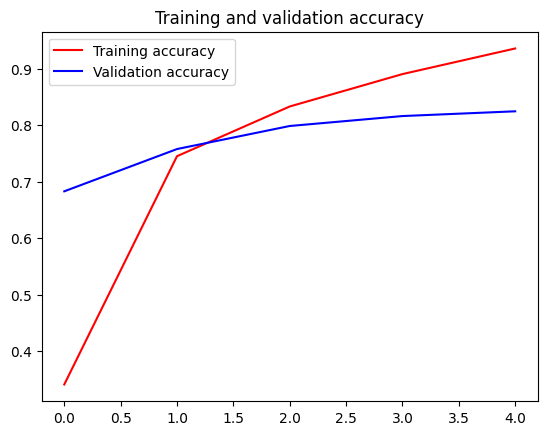

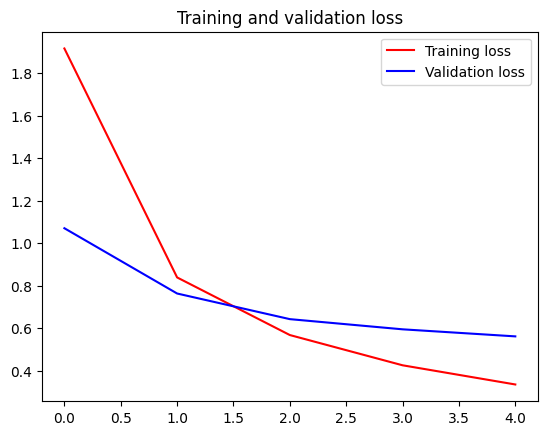

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_acc_curves(resnet_history)

In [ ]:
# Model Summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23561152  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


Now it is time to do the same with the other two models `ResNet-50-v2` and `EfficientNetB0` and compare their results.

In [ ]:
# Create a model via EfficientNetB0
efficientnet_model = create_model(resnet50v2_url,
                                  num_classes=train_data.num_classes)

# Compile the model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_dir",
                                                                                     experiment_name="tensorflow_exp_resnet50V2")])
                                            )